In [ ]:
import pandas as pd
#import modules and test files

train_set = pd.read_csv("./tidy_text_data.csv")
train_set.head()
train_set = train_set[:1288]

In [ ]:
import pandas as pd
import spacy
import re
import nltk

from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from nltk.corpus import stopwords

In [4]:
# Helper function    
def lemmatize(word_list, ptags):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    spC = spacy.load('en_core_web_sm')
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    
    return lem_lists

In [5]:
import numpy as np 
import spacy
import nltk as nltk

import re
# import wordcloud
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
st_words = stopwords.words('english')
extra_stops=['from','subject','re', 'edu','use']
st_words.extend(extra_stops)

In [6]:
#Preprocessing
doc_list = train_set.text_new.values.tolist()
word_list = [simple_preprocess(str(txt), deacc=True, min_len=3) for txt in doc_list]
bigram = Phrases(word_list, min_count=5, threshold=100) # use original wordlist to build model
bigram_model = Phraser(bigram)
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]
word_list_lemmatized = lemmatize(word_bigrams, ptags=['NOUN','VERB','ADV','ADJ'])
word_list_lemmatized[0][:7]



['lean', 'empty', 'guard', 'desk', 'hear', 'footstep', 'straighten']

In [7]:

list_to_remove = []
for i, word_list in enumerate(word_list_lemmatized):
    if len(word_list) == 0:
        list_to_remove.append(i)
list_to_remove.reverse()
for index in list_to_remove:
    word_list_lemmatized.pop(index)

In [8]:
len(word_list_lemmatized[0])

15

In [9]:
len(word_list_lemmatized)

1285

In [10]:
import tomotopy as tp
term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1,
                  alpha=0.1, initial_k=10, seed=99999)
                  

In [11]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys

def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp
    
        
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [12]:
tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1,
                     initial_k=10, seed=99999)
    
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel(hdp, word_list_lemmatized, mcmc_iter=1000)
    hdp.save(''.join(['models/hdp_model_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))
    

Training...


Model one
Num docs: 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -6.8804074987055355	Num. of topics: 110
Iteration: 100	Log-likelihood: -6.895842616548205	Num. of topics: 208
Iteration: 200	Log-likelihood: -6.904718082149236	Num. of topics: 206
Iteration: 300	Log-likelihood: -6.901787545080371	Num. of topics: 228
Iteration: 400	Log-likelihood: -6.909524140398154	Num. of topics: 216
Iteration: 500	Log-likelihood: -6.907194753587775	Num. of topics: 223
Iteration: 600	Log-likelihood: -6.90167883755821	Num. of topics: 230
Iteration: 700	Log-likelihood: -6.894259342087718	Num. of topics: 234
Iteration: 800	Log-likelihood: -6.896010665957706	Num. of topics: 223
Iteration: 900	Log-likelihood: -6.898436099890066	Num. of topics: 223
Done

Model pmi
Num docs:

Training...


 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -6.386629149167401	Num. of topics: 56
Iteration: 100	Log-likelihood: -6.345740677944633	Num. of topics: 65
Iteration: 200	Log-likelihood: -6.330217913508407	Num. of topics: 73
Iteration: 300	Log-likelihood: -6.364747564834963	Num. of topics: 63
Iteration: 400	Log-likelihood: -6.344810801790255	Num. of topics: 69
Iteration: 500	Log-likelihood: -6.339224935505748	Num. of topics: 67
Iteration: 600	Log-likelihood: -6.3291523836576165	Num. of topics: 66
Iteration: 700	Log-likelihood: -6.320432023537772	Num. of topics: 72
Iteration: 800	Log-likelihood: -6.288931835273628	Num. of topics: 79


Training...


Iteration: 900	Log-likelihood: -6.2675105757619125	Num. of topics: 88
Done

Model idf
Num docs: 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -6.468302396314163	Num. of topics: 38
Iteration: 100	Log-likelihood: -6.3886863274315076	Num. of topics: 52
Iteration: 200	Log-likelihood: -6.395660426936864	Num. of topics: 54
Iteration: 300	Log-likelihood: -6.37958640586482	Num. of topics: 64
Iteration: 400	Log-likelihood: -6.360823949771535	Num. of topics: 64
Iteration: 500	Log-likelihood: -6.347706002789749	Num. of topics: 66
Iteration: 600	Log-likelihood: -6.314296795825154	Num. of topics: 86
Iteration: 700	Log-likelihood: -6.285377000386036	Num. of topics: 77
Iteration: 800	Log-likelihood: -6.280468257316098	Num. of topics: 88
Iteration: 900	Log-likelihood: -6.285509108777124	Num. of topics: 79
Done



In [13]:
hdp_model = tp.HDPModel.load("models/hdp_model_idf.bin")

# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
cands = extractor.extract(hdp_model)

labeler = tp.label.FoRelevance(hdp_model, cands, min_df=5, smoothing=1e-2, mu=0.7)
for k in range(hdp_model.k):
    
    if not hdp_model.is_live_topic(k): continue
        
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in hdp_model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()
    

== Topic #0 ==
Labels: simply, city, name, street, long
pig	0.11738771200180054
combine	0.11738771200180054
produce	0.11028262972831726
farm	0.10746292024850845
name	0.08919728547334671
new	0.07885978370904922
friend	0.07456051558256149
long	0.0638851672410965
go	0.05658937990665436
old	0.00021133522386662662

== Topic #1 ==
Labels: mountain, middle, animal, visit, sun
sun	0.060417260974645615
decide	0.051260191947221756
ray	0.03979083150625229
period	0.03979083150625229
silent	0.03738025948405266
cool	0.03738025575876236
explore	0.03738025575876236
slowly	0.03642360493540764
cast	0.03642360121011734
warm	0.035579781979322433

== Topic #2 ==
Labels: make sense, discover, include, huge, explain
wonder	0.1307528167963028
aware	0.06607313454151154
include	0.05782723054289818
huge	0.05782723054289818
discover	0.05782723054289818
explain	0.049581315368413925
show	0.04741236940026283
able	0.04646016284823418
sense	0.04601117596030235
simply	0.04436768963932991

== Topic #3 ==
Labels: fruit, 

In [14]:
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

In [15]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, word_list_lemmatized)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



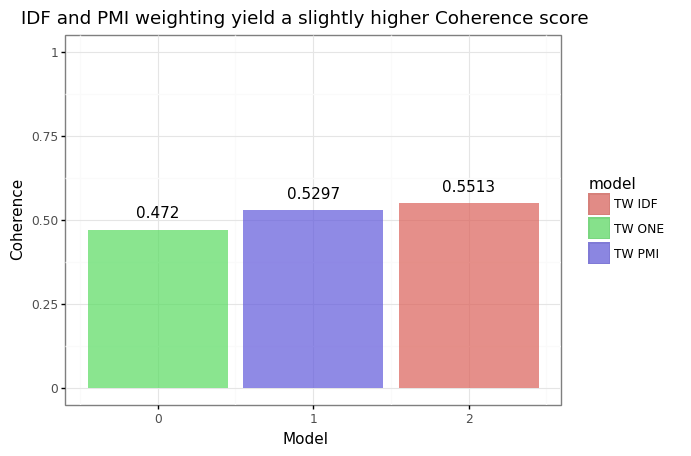

<ggplot: (90164587752)>

In [16]:
# Plotting
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_histogram, labs, theme_bw, scale_x_continuous, \
                    geom_bar, theme, lims, geom_text, position_dodge
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)

In [17]:
hdp_one = tp.HDPModel.load("models/hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load("models/hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load("models/hdp_model_idf.bin")

In [18]:
#check for same top three topics 
def check_congurent_topics(list):
    for i in range(len(list)):
        for j in range(len(list)):
            if list[i] == list[j]:
                return True
            else:
                return False
    

In [37]:
#Pulling top 3 labels for potential topics 

topics_df = pd.DataFrame(columns=["entry", "lemmatized", "topic_id", "top_three_labels"])

for i in range(len(word_list_lemmatized)):
    test_doc = word_list_lemmatized[i]
    doc_init = hdp_idf.make_doc(test_doc)
    topic_dist, learned_labels = hdp_idf.infer(doc_init, together=True)
    topic_id = np.array(topic_dist).argmax()
    topic_freqs = dict(hdp_idf.get_topic_words(topic_id))
    topic_keys = list(topic_freqs.keys())
    top_three_topics = topic_keys[:3]
    to_append = [train_set.text_new[i], test_doc, str(topic_id), str(top_three_topics)]
    topics_df.loc[i] = to_append
    
    
    

In [38]:
topics_df.head

<bound method NDFrame.head of                                                   entry  \
0     James was leaning against the empty guard desk...   
1     There was no clock on the nightstand between t...   
2     Finley should’ve been happier — he should’ve b...   
3     Inside a Belizean cave, you wade deeper into g...   
4     Sophie had forgotten him by then. Not complete...   
...                                                 ...   
1280                         blagh class at 8 tomorrow    
1281     I hate when I have to call and wake people up    
1282  Just going to cry myself to sleep after watchi...   
1283                             im sad now  Miss.Lilly   
1284  ooooh.... LOL  that leslie.... and ok I won't ...   

                                             lemmatized topic_id  \
0     [lean, empty, guard, desk, hear, footstep, str...        5   
1     [nightstand, bed, analogue, phone, brochure, t...        5   
2     [happy, beam, hardwood, car, job, girlfriend, ...  